<a href="https://colab.research.google.com/github/Cimbir/Store-Sales-Forecasting/blob/main/model_n_beats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 114.1 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
!mkdir ~/.kaggle
!echo "{\"username\":\"dachisuramelashvili\",\"key\":\"4202ec60e20b612a9947450bb8aeebb5\"}" > ~/.kaggle
!cp /content/drive/MyDrive/ML/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

/bin/bash: line 1: /root/.kaggle: Is a directory


In [3]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 661MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [4]:
!unzip train.csv.zip
!unzip stores.csv.zip
!unzip features.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  test.csv.zip
  inflating: test.csv                


In [5]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from time import time
import pickle
import seaborn as sns
import random

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [6]:
import warnings
warnings.filterwarnings('ignore')

# Evaluate

In [7]:
def WMAE(dataset, real, predict):
    weights = dataset['IsHoliday_x'].apply(lambda x: 5 if x else 1)
    return (np.sum(weights * abs(real - predict)) / np.sum(weights))

In [8]:
class WeightedMAELoss(nn.Module):
    def __init__(self):
        super(WeightedMAELoss, self).__init__()

    def forward(self, y_pred, y_true, holidays):
      weights = torch.where(holidays == 1, torch.tensor(5.0).to(holidays.device), torch.tensor(1.0).to(holidays.device))
      mae = torch.abs(y_pred - y_true)
      return (weights * mae).mean()

# Get Data

In [9]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

test_df = pd.read_csv('test.csv')

In [10]:
df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1)

df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Unique stores: {df['Store'].nunique()}")
print(f"Unique departments: {df['Dept'].nunique()}")

test_df['Date'] = pd.to_datetime(test_df['Date'])

print(f"Test dataset shape: {test_df.shape}")
print(f"Test date range: {test_df['Date'].min()} to {test_df['Date'].max()}")

display(df.head())

Dataset shape: (421570, 16)
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Unique stores: 45
Unique departments: 81
Test dataset shape: (115064, 4)
Test date range: 2012-11-02 00:00:00 to 2013-07-26 00:00:00


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


# Visualize data

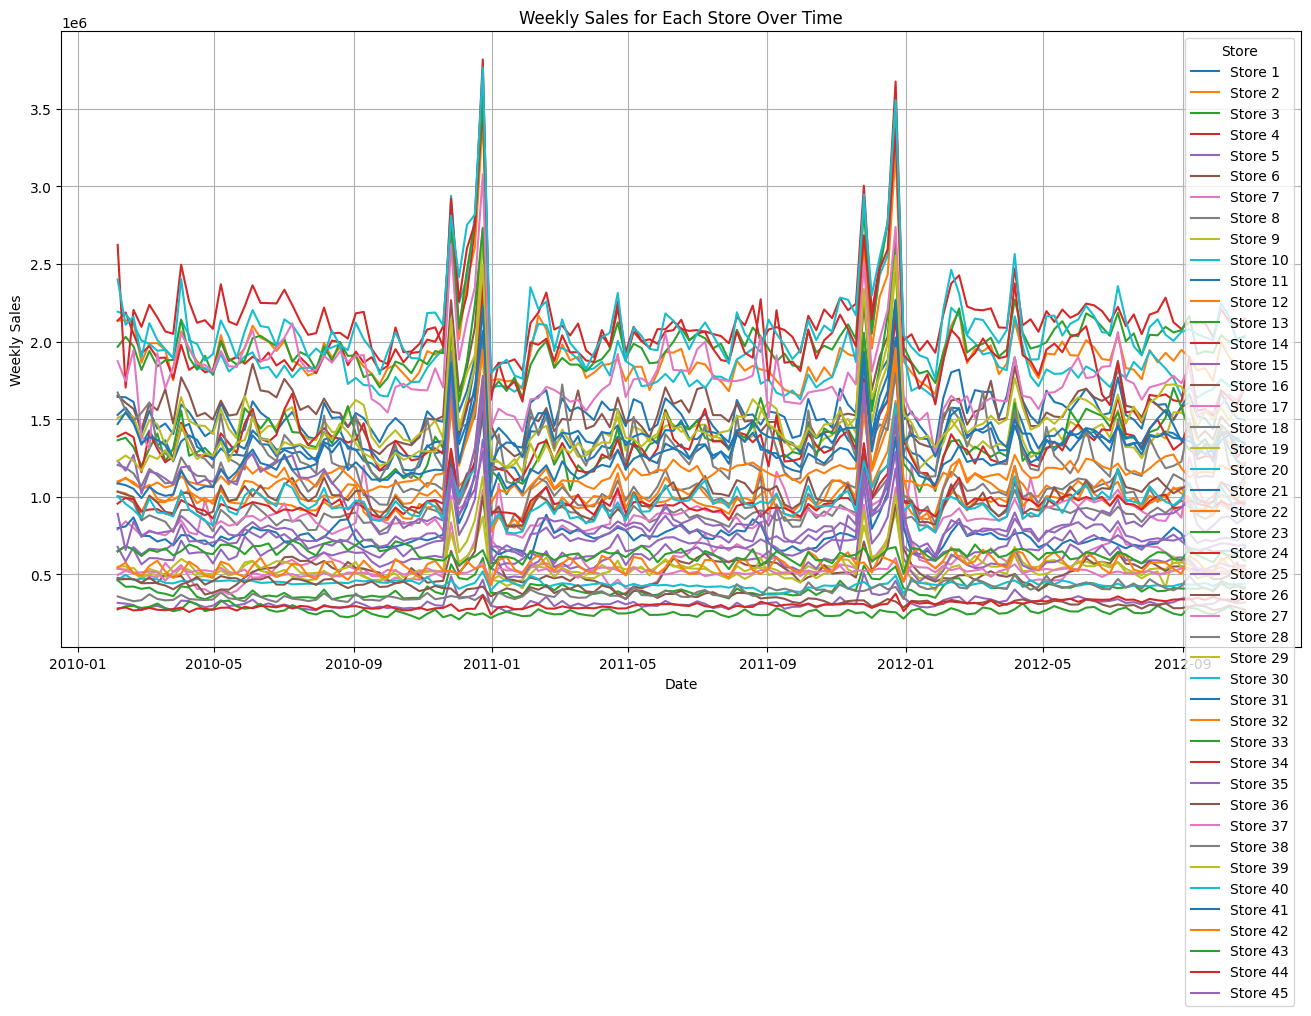

In [11]:
# Group by Store and Date to get weekly sales for each store
weekly_sales_by_store = df.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()

# Pivot the data to have Stores as columns and Dates as index
weekly_sales_pivot = weekly_sales_by_store.pivot(index='Date', columns='Store', values='Weekly_Sales')

# Plot the weekly sales for each store
plt.figure(figsize=(16, 8))
for store in weekly_sales_pivot.columns:
    plt.plot(weekly_sales_pivot.index, weekly_sales_pivot[store], label=f'Store {store}')

plt.title('Weekly Sales for Each Store Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(title='Store')
plt.grid(True)
plt.show()

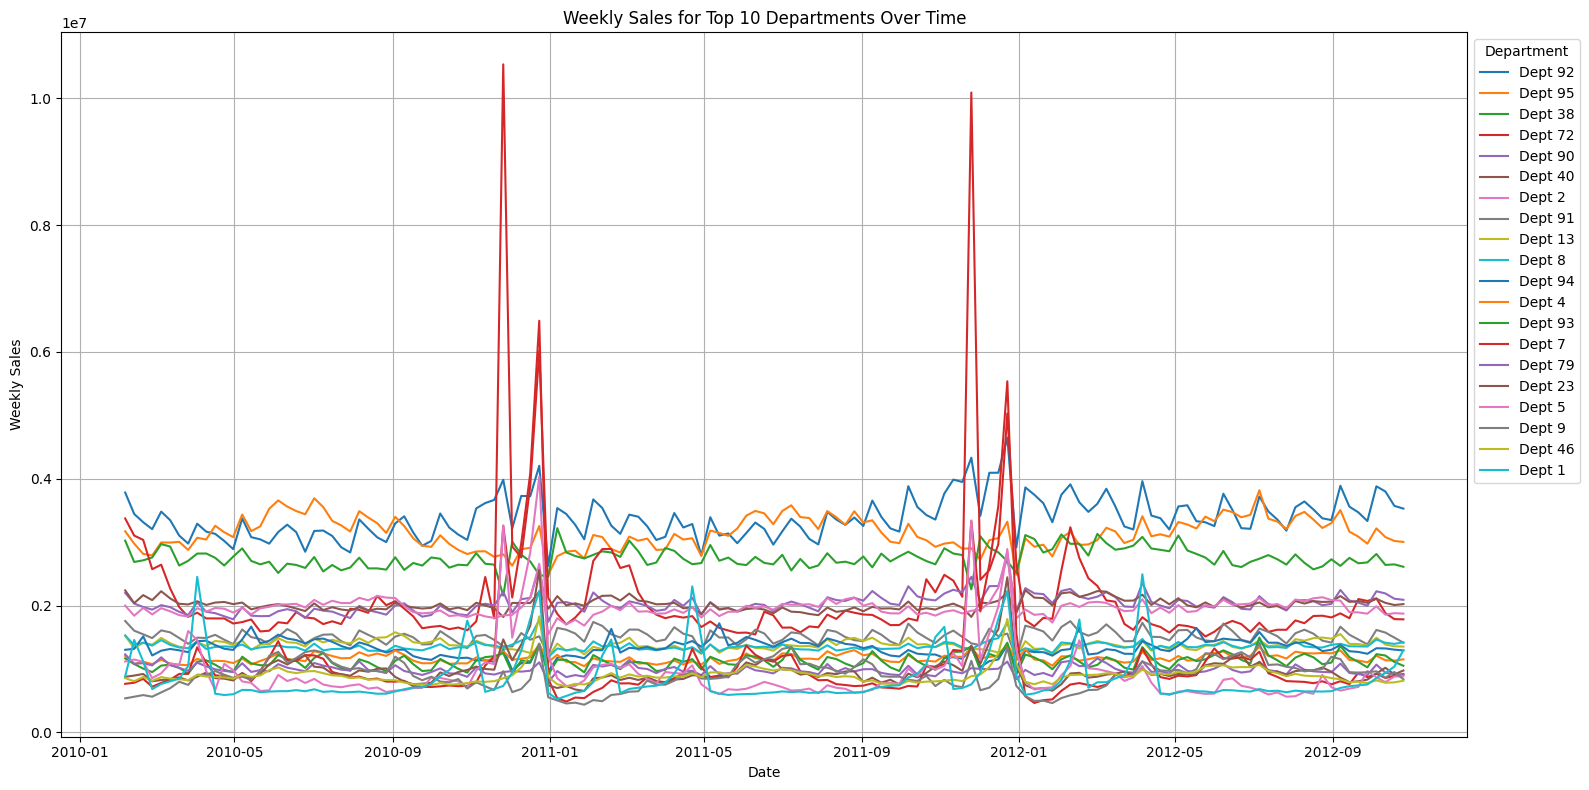

In [12]:
# Group by Department and Date to get weekly sales for each department
weekly_sales_by_dept = df.groupby(['Dept', 'Date'])['Weekly_Sales'].sum().reset_index()

# Pivot the data to have Departments as columns and Dates as index
weekly_sales_pivot_dept = weekly_sales_by_dept.pivot(index='Date', columns='Dept', values='Weekly_Sales')

# Plot the weekly sales for each department (plotting too many lines might be cluttered)
# Let's plot sales for a few departments as an example
plt.figure(figsize=(16, 8))
top_depts = df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(20).index

for dept in top_depts:
    if dept in weekly_sales_pivot_dept.columns:
        plt.plot(weekly_sales_pivot_dept.index, weekly_sales_pivot_dept[dept], label=f'Dept {dept}')

plt.title('Weekly Sales for Top 10 Departments Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(title='Department', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

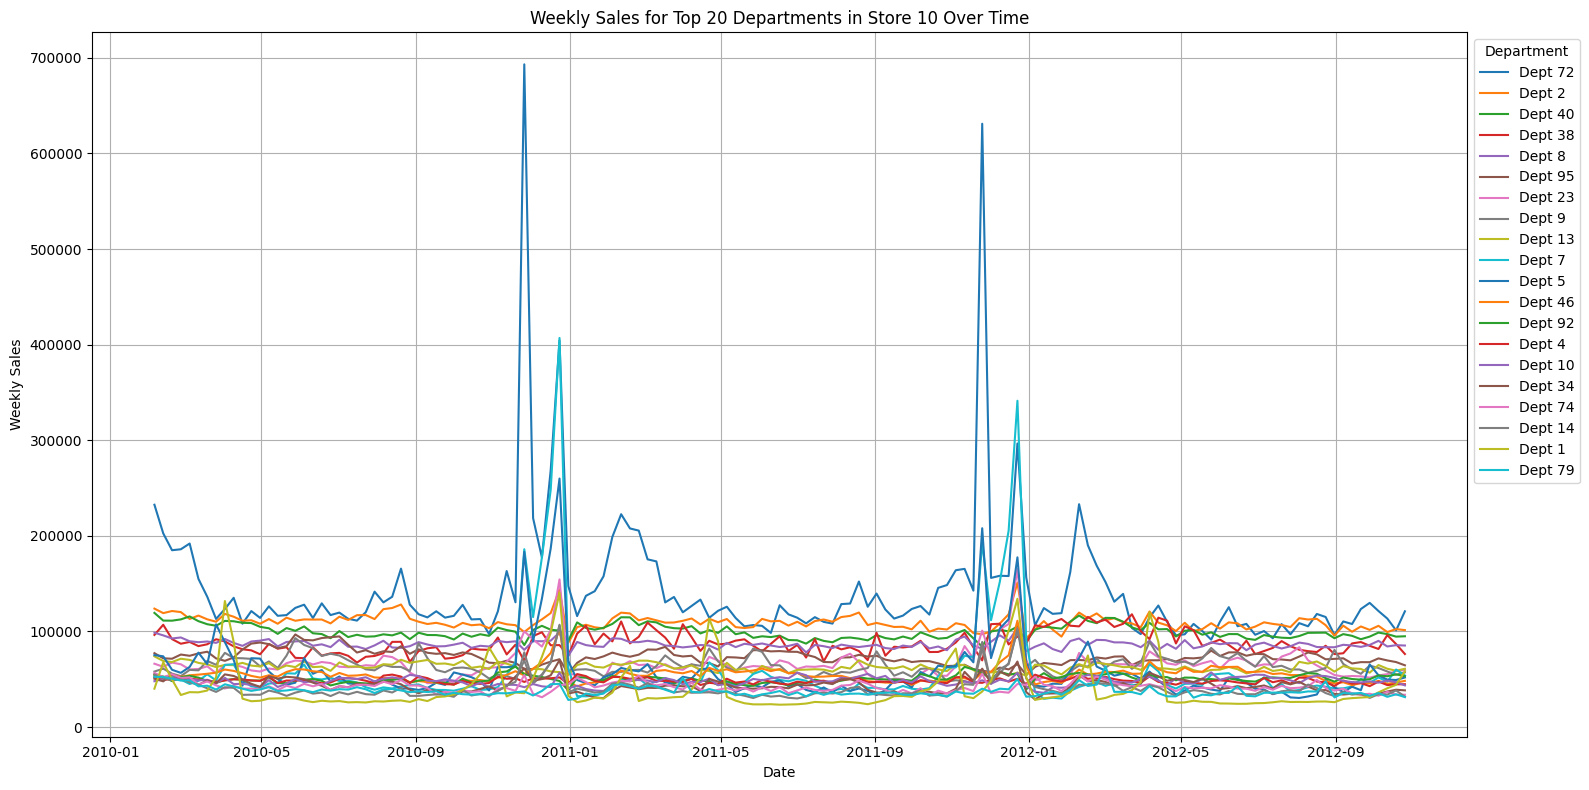

In [13]:
# Choose a store ID
store_id = 10  # You can change this to the store you are interested in

# Filter data for the selected store
store_df = df[df['Store'] == store_id].copy()

# Group by Department and Date to get weekly sales for each department in the selected store
weekly_sales_by_dept_store = store_df.groupby(['Dept', 'Date'])['Weekly_Sales'].sum().reset_index()

# Pivot the data to have Departments as columns and Dates as index
weekly_sales_pivot_dept_store = weekly_sales_by_dept_store.pivot(index='Date', columns='Dept', values='Weekly_Sales').fillna(0)

# Get the total sales for each department across all weeks for this store to find the top 20 departments
department_total_sales = weekly_sales_pivot_dept_store.sum().sort_values(ascending=False)

# Select the top 20 departments for this store
top_20_depts_store = department_total_sales.head(20).index

# Filter the pivoted data to include only the top 20 departments
weekly_sales_pivot_dept_store_top20 = weekly_sales_pivot_dept_store[top_20_depts_store]

# Plot the weekly sales for the top 20 departments in the selected store
plt.figure(figsize=(16, 8))

for dept in weekly_sales_pivot_dept_store_top20.columns:
    plt.plot(weekly_sales_pivot_dept_store_top20.index, weekly_sales_pivot_dept_store_top20[dept], label=f'Dept {dept}')

plt.title(f'Weekly Sales for Top 20 Departments in Store {store_id} Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(title='Department', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

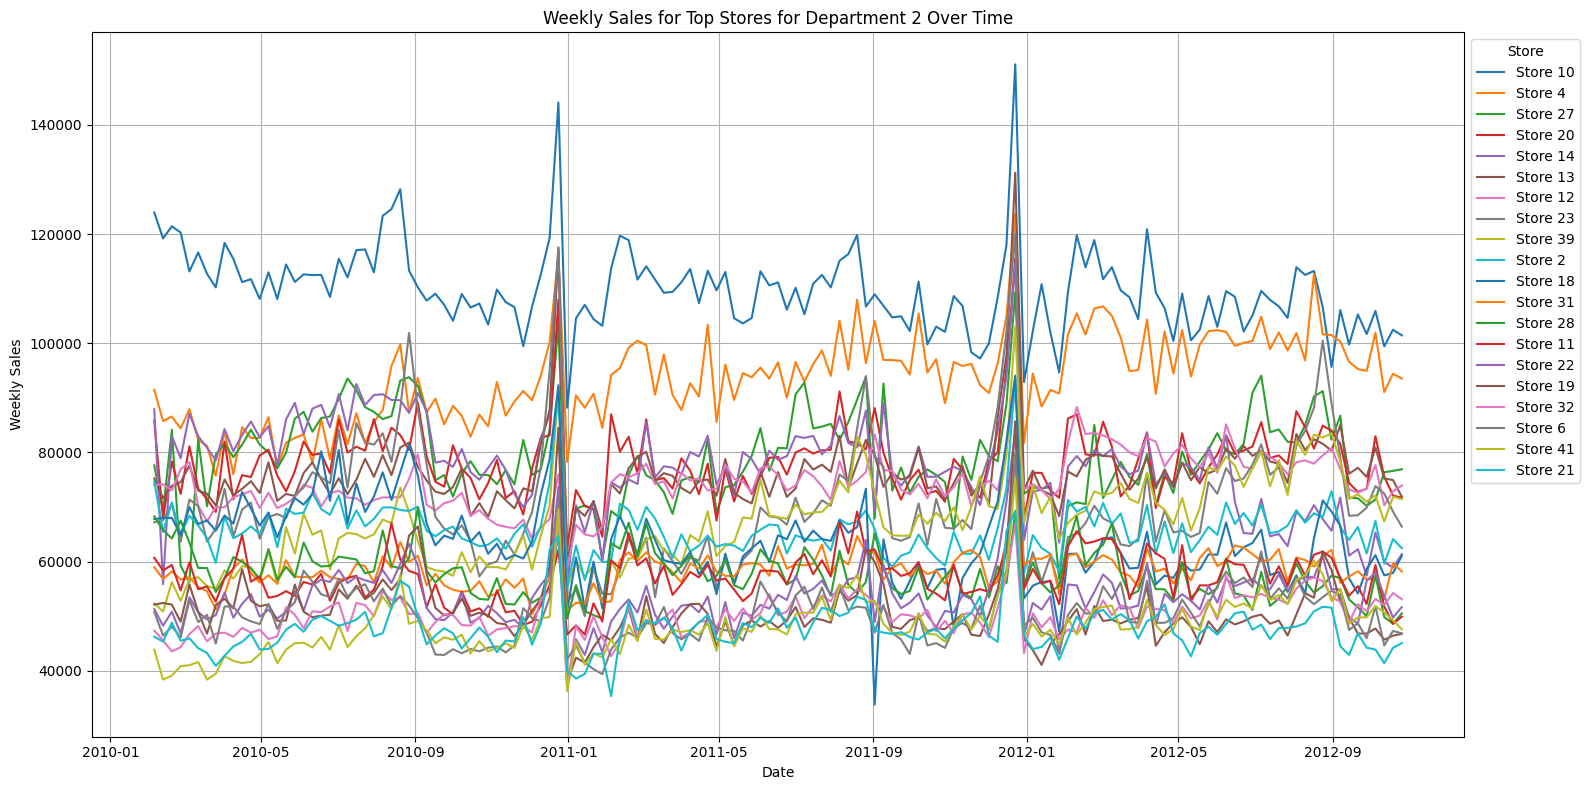

In [14]:
# Choose a department ID
dept_id = 2  # You can change this to the department you are interested in

# Filter data for the selected department
dept_df = df[df['Dept'] == dept_id].copy()

# Group by Store and Date to get weekly sales for each store in the selected department
weekly_sales_by_store_dept = dept_df.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()

# Pivot the data to have Stores as columns and Dates as index
weekly_sales_pivot_store_dept = weekly_sales_by_store_dept.pivot(index='Date', columns='Store', values='Weekly_Sales').fillna(0)

# Get the total sales for each store across all weeks for this department to find the top stores
store_total_sales = weekly_sales_pivot_store_dept.sum().sort_values(ascending=False)

# Select the top 20 stores for this department (or all stores if less than 20)
top_stores_dept = store_total_sales.head(20).index

# Filter the pivoted data to include only the top stores
weekly_sales_pivot_store_dept_top_stores = weekly_sales_pivot_store_dept[top_stores_dept]

# Plot the weekly sales for the top stores in the selected department
plt.figure(figsize=(16, 8))

for store in weekly_sales_pivot_store_dept_top_stores.columns:
    plt.plot(weekly_sales_pivot_store_dept_top_stores.index, weekly_sales_pivot_store_dept_top_stores[store], label=f'Store {store}')

plt.title(f'Weekly Sales for Top Stores for Department {dept_id} Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(title='Store', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Preprocessing

In [15]:
class CleaningPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, nan_vars):
        self.nan_vars = nan_vars

    def fit(self, X, y=None):
        self.var_to_mean = {}
        for var in self.nan_vars:
            self.var_to_mean[var] = X[var].mean()
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.nan_vars:
            X[var].fillna(self.var_to_mean[var], inplace=True)
        return X

class EncoderPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['IsHoliday_x'] = X['IsHoliday_x'].astype(int)
        return X

class FormatterPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X.sort_values(['Date', 'Store', 'Dept'])
        X = X.set_index('Date')
        X.index = pd.to_datetime(X.index)
        return X

class SelectionPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, feature_cols):
        self.feature_cols = feature_cols
        self.selected_feature_cols = []

    def fit(self, X, y=None):
        self.selected_feature_cols = [col for col in self.feature_cols if col in X.columns]
        return self

    def transform(self, X):
        X = X.copy()
        return X[self.selected_feature_cols]

class ScalerPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X)
        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        return pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# N-BEATS Model Implementation

## Basis

In [16]:
class GenericBasis(nn.Module):
    """
    Generic basis function (simple linear transformation)
    """
    def __init__(self, backcast_size, forecast_size):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta, input_size, mode):
        if mode == 'backcast':
            return theta[:, :self.backcast_size]
        else:  # forecast
            return theta[:, :self.forecast_size]


class TrendBasis(nn.Module):
    """
    Trend basis function using polynomial basis
    """
    def __init__(self, degree_of_polynomial, backcast_size, forecast_size):
        super().__init__()
        self.degree_of_polynomial = degree_of_polynomial
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta, input_size, mode):
        batch_size = theta.size(0)

        if mode == 'backcast':
            t = torch.arange(0, self.backcast_size, dtype=torch.float32) / self.backcast_size
        else:  # forecast
            t = torch.arange(self.backcast_size, self.backcast_size + self.forecast_size, dtype=torch.float32) / self.backcast_size

        t = t.to(theta.device)
        T = torch.stack([t ** i for i in range(self.degree_of_polynomial + 1)], dim=0).T  # [time, degree]
        T = T.unsqueeze(0).expand(batch_size, -1, -1)  # [batch, time, degree]

        theta = theta.unsqueeze(-1)  # [batch, degree, 1]

        return torch.bmm(T, theta).squeeze(-1)  # [batch, time]


class SeasonalityBasis(nn.Module):
    """
    Seasonality basis function using Fourier series
    """
    def __init__(self, harmonics, backcast_size, forecast_size):
        super().__init__()
        self.harmonics = harmonics
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta, input_size, mode):
        batch_size = theta.size(0)

        if mode == 'backcast':
            t = torch.arange(0, self.backcast_size, dtype=torch.float32)
        else:  # forecast
            t = torch.arange(self.backcast_size, self.backcast_size + self.forecast_size, dtype=torch.float32)

        t = t.to(theta.device)

        # Create Fourier basis
        S = torch.zeros(len(t), 2 * self.harmonics).to(theta.device)
        for i in range(self.harmonics):
            S[:, 2*i] = torch.sin(2 * np.pi * (i + 1) * t / self.backcast_size)
            S[:, 2*i + 1] = torch.cos(2 * np.pi * (i + 1) * t / self.backcast_size)

        S = S.unsqueeze(0).expand(batch_size, -1, -1)  # [batch, time, 2*harmonics]
        theta = theta.unsqueeze(-1)  # [batch, 2*harmonics, 1]

        return torch.bmm(S, theta).squeeze(-1)  # [batch, time]

## Block

In [17]:
class NBeatsBlock(nn.Module):
    """
    N-BEATS block which takes a basis expansion as an argument.
    Modified to handle multivariate input (sales + features).
    """
    def __init__(self, input_size, theta_size, basis_function, layers, layer_size):
        super().__init__()
        self.input_size = input_size  # backcast_length
        self.theta_size = theta_size
        self.basis_function = basis_function

        # Total input size is backcast_length * (1 + feature_size)
        # 1 for sales + feature_size for additional features
        total_input_size = input_size * (1)

        # Fully connected stack
        layers_list = [nn.Linear(total_input_size, layer_size), nn.ReLU()]
        for _ in range(layers - 1):
            layers_list.append(nn.Linear(layer_size, layer_size))
            layers_list.append(nn.ReLU())

        self.fc_stack = nn.Sequential(*layers_list)

        # Theta layers (coefficients for basis functions)
        self.theta_b_fc = nn.Linear(layer_size, theta_size)
        self.theta_f_fc = nn.Linear(layer_size, theta_size)

    def forward(self, x):
        # x shape: [batch_size, backcast_length] (sales data)
        # features shape: [batch_size, backcast_length, feature_size]

        # Flatten and concatenate sales with features
        batch_size = x.size(0)
        x_flat = x.flatten(1)  # [batch_size, backcast_length]

        # Pass through fully connected stack
        h = self.fc_stack(x_flat)

        # Get theta coefficients
        theta_b = self.theta_b_fc(h)
        theta_f = self.theta_f_fc(h)

        # Generate basis functions and apply theta coefficients
        backcast = self.basis_function(theta_b, x.size(-1), 'backcast')
        forecast = self.basis_function(theta_f, x.size(-1), 'forecast')

        return backcast, forecast

## Stack

In [18]:
class NBeatsStack(nn.Module):
    """
    N-BEATS stack containing multiple blocks of the same type
    """
    def __init__(self,
                 stack_type,
                 backcast_length,
                 forecast_length,
                 nb_blocks,
                 hidden_layer_units,
                 nb_layers,
                 theta_dim,
                 share_weights=False):
        super().__init__()

        self.stack_type = stack_type
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.nb_blocks = nb_blocks
        self.share_weights = share_weights

        # Create basis function based on stack type
        if stack_type == 'generic':
            self.basis_function = GenericBasis(backcast_length, forecast_length)
            theta_size = backcast_length + forecast_length
        elif stack_type == 'trend':
            self.basis_function = TrendBasis(theta_dim - 1, backcast_length, forecast_length)
            theta_size = theta_dim
        elif stack_type == 'seasonality':
            self.basis_function = SeasonalityBasis(theta_dim // 2, backcast_length, forecast_length)
            theta_size = theta_dim
        else:
            raise ValueError(f"Unknown stack type: {stack_type}")

        # Create blocks
        self.blocks = nn.ModuleList()

        if share_weights and nb_blocks > 1:
            # Share weights across blocks in the stack
            shared_block = NBeatsBlock(
                input_size=backcast_length,
                theta_size=theta_size,
                basis_function=self.basis_function,
                layers=nb_layers,
                layer_size=hidden_layer_units
            )
            self.blocks = nn.ModuleList([shared_block for _ in range(nb_blocks)])
        else:
            # Create separate blocks
            for _ in range(nb_blocks):
                block = NBeatsBlock(
                    input_size=backcast_length,
                    theta_size=theta_size,
                    basis_function=self.basis_function,
                    layers=nb_layers,
                    layer_size=hidden_layer_units
                )
                self.blocks.append(block)

    def forward(self, x):
        """
        Forward pass through the stack

        Args:
            x: [batch_size, backcast_length] - sales residuals

        Returns:
            residuals: [batch_size, backcast_length] - updated residuals after this stack
            forecast: [batch_size, forecast_length] - forecast contribution from this stack
        """
        residuals = x
        forecast = torch.zeros(x.size(0), self.forecast_length).to(x.device)

        for block in self.blocks:
            backcast, block_forecast = block(residuals)
            residuals = residuals - backcast
            forecast = forecast + block_forecast

        return residuals, forecast

## Model

In [19]:
class NBeatsModel(nn.Module):
    """
    N-BEATS model implementation with multivariate support
    """
    def __init__(self,
                 backcast_length=52,  # Look back 20 weeks
                 forecast_length=10,  # Forecast 10 weeks ahead
                 stack_types=['trend', 'seasonality', 'generic'],
                 nb_blocks_per_stack=3,
                 hidden_layer_units=512,
                 nb_layers=4,
                 share_weights_in_stack=False,
                 thetas_dim=[4, 8, 8]):
        super().__init__()

        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.hidden_layer_units = hidden_layer_units
        self.nb_layers = nb_layers
        self.thetas_dim = thetas_dim

        # Create stacks using NBeatsStack class
        self.stacks = nn.ModuleList()

        for stack_id, stack_type in enumerate(stack_types):
            stack = NBeatsStack(
                stack_type=stack_type,
                backcast_length=backcast_length,
                forecast_length=forecast_length,
                nb_blocks=nb_blocks_per_stack,
                hidden_layer_units=hidden_layer_units,
                nb_layers=nb_layers,
                theta_dim=thetas_dim[stack_id],
                share_weights=share_weights_in_stack
            )
            self.stacks.append(stack)

    def forward(self, x):
        # x shape: [batch_size, backcast_length] (sales data)
        residuals = x
        forecast = torch.zeros(x.size(0), self.forecast_length).to(x.device)

        for stack in self.stacks:
            stack_residuals, stack_forecast = stack(residuals)

            residuals = stack_residuals
            forecast = forecast + stack_forecast

        return forecast

# Dataset

In [20]:
class SalesDataset(Dataset):
    def __init__(self, sales_df, backcast_length, forecast_length):
        self.sales_df = sales_df
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

        # Create sequences
        self.sequences = []
        sales_data = sales_df['Weekly_Sales'].values
        holiday_data = sales_df['IsHoliday_x'].values
        for i in range(len(sales_data) - backcast_length - forecast_length + 1):
            # Sales sequences
            sales_backcast = sales_data[i:i + backcast_length]
            sales_forecast = sales_data[i + backcast_length:i + backcast_length + forecast_length]
            holiday_forecast = holiday_data[i + backcast_length:i + backcast_length + forecast_length]

            self.sequences.append((sales_backcast, sales_forecast, holiday_forecast))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sales_backcast, sales_forecast, holiday_forecast = self.sequences[idx]
        return (torch.FloatTensor(sales_backcast),
                torch.FloatTensor(sales_forecast),
                torch.FloatTensor(holiday_forecast))

# Prepare Dataset

In [ ]:
# Handle missing data
nan_vars = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Select features to use (excluding target and identifiers)
feature_cols = ['Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
                'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']

store_ids = [10]
dept_ids = [2]

# Create preprocessing pipeline
preprocessor = Pipeline([
    ('cleaner', CleaningPreprocessor(nan_vars=nan_vars)),
    ('encoder', EncoderPreprocessor()),
    ('formatter', FormatterPreprocessor()),
    ('selector', SelectionPreprocessor(feature_cols=feature_cols)),
    ('scaler', ScalerPreprocessor()),
])

# Fit and transform the data
df_p = preprocessor.fit_transform(df.copy())

df_p.head(100)

NameError: name 'CleaningPreprocessor' is not defined

# Split


In [21]:
# Model parameters
BACKCAST_LENGTH = 52
FORECAST_LENGTH = 30
BATCH_SIZE = 16
LR = 0.001
EPOCHS = 100
TRIALS = 50

STACK_TYPES = ['trend', 'seasonality', 'generic']
NB_BLOCKS_PER_STACK = 3
HIDDEN_LAYER_UNITS = 256
NB_LAYERS = 4
THETA_DIM = [4, 8, 8]

In [22]:
store_id = 9
dept_id = 9

df_sd = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)]

In [23]:
train_end_date = df_sd['Date'].iloc[-(FORECAST_LENGTH)]
val_start_date = df_sd['Date'].iloc[-(BACKCAST_LENGTH + FORECAST_LENGTH + 1)]

df_train = df_sd[df_sd['Date'] < train_end_date]
df_val = df_sd[df_sd['Date'] > val_start_date]

In [24]:
print(f"Training data shape: {df_train.shape}")
print(f"Validation data shape: {df_val.shape}")

Training data shape: (113, 16)
Validation data shape: (82, 16)


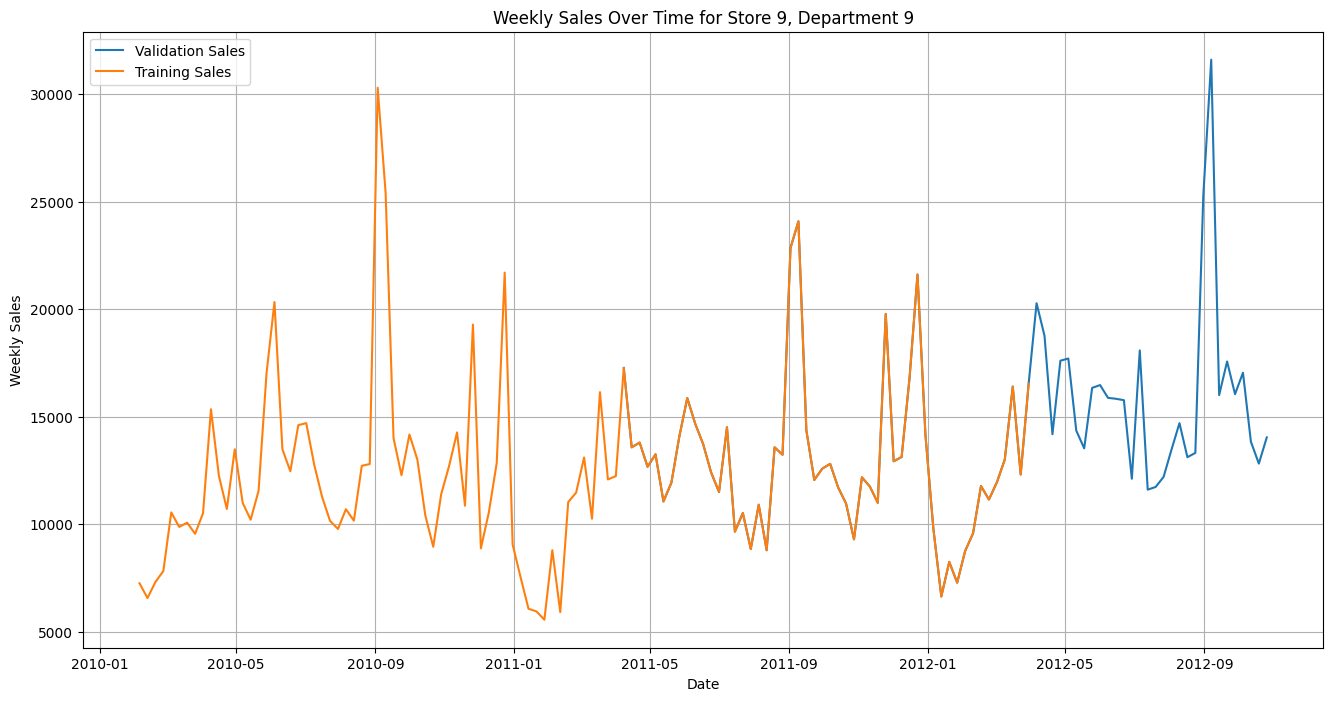

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))

plt.plot(df_val['Date'], df_val['Weekly_Sales'], label='Validation Sales')
plt.plot(df_train['Date'], df_train['Weekly_Sales'], label='Training Sales')

plt.title(f'Weekly Sales Over Time for Store {store_id}, Department {dept_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Create datasets
train_dataset = SalesDataset(df_train, BACKCAST_LENGTH, FORECAST_LENGTH)
val_dataset = SalesDataset(df_val, BACKCAST_LENGTH, FORECAST_LENGTH)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 2
Val batches: 1


# Train Model

In [28]:
# Initialize model
model = NBeatsModel(
    backcast_length=BACKCAST_LENGTH,
    forecast_length=FORECAST_LENGTH,
    stack_types=['trend', 'seasonality', 'generic'],
    nb_blocks_per_stack=3,
    hidden_layer_units=256,
    nb_layers=4,
    thetas_dim=[4, 8, 8]
).to(device)

# Loss function and optimizer
criterion = WeightedMAELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Backcast length: {BACKCAST_LENGTH}")
print(f"Forecast length: {FORECAST_LENGTH}")
print(model)

Model parameters: 2,043,444
Backcast length: 52
Forecast length: 30
NBeatsModel(
  (stacks): ModuleList(
    (0): NBeatsStack(
      (basis_function): TrendBasis()
      (blocks): ModuleList(
        (0-2): 3 x NBeatsBlock(
          (basis_function): TrendBasis()
          (fc_stack): Sequential(
            (0): Linear(in_features=52, out_features=256, bias=True)
            (1): ReLU()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): ReLU()
            (4): Linear(in_features=256, out_features=256, bias=True)
            (5): ReLU()
            (6): Linear(in_features=256, out_features=256, bias=True)
            (7): ReLU()
          )
          (theta_b_fc): Linear(in_features=256, out_features=4, bias=True)
          (theta_f_fc): Linear(in_features=256, out_features=4, bias=True)
        )
      )
    )
    (1): NBeatsStack(
      (basis_function): SeasonalityBasis()
      (blocks): ModuleList(
        (0-2): 3 x NBeatsBlock(
          (basi

In [86]:
def training(train_loader, val_loader, model, criterion, optimizer, scheduler, num_epochs=EPOCHS, log=True):
  # Training loop
  train_losses = []
  val_losses = []
  best_val_loss = float('inf')

  for epoch in range(num_epochs):
      # Training
      model.train()
      train_loss = 0.0

      for batch_idx, (sales_backcast, sales_forecast_true, holiday_forecast) in enumerate(train_loader):
          sales_backcast = sales_backcast.to(device)
          sales_forecast_true = sales_forecast_true.to(device)
          holiday_forecast = holiday_forecast.to(device)

          optimizer.zero_grad()
          sales_forecast_pred = model(sales_backcast)
          loss = criterion(sales_forecast_pred, sales_forecast_true, holiday_forecast)
          loss.backward()
          optimizer.step()

          train_loss += loss.item()

      # Validation
      model.eval()
      val_loss = 0.0

      with torch.no_grad():
          for sales_backcast, sales_forecast_true, holiday_forecast in val_loader:
              sales_backcast = sales_backcast.to(device)
              sales_forecast_true = sales_forecast_true.to(device)
              holiday_forecast = holiday_forecast.to(device)

              sales_forecast_pred = model(sales_backcast)
              loss = criterion(sales_forecast_pred, sales_forecast_true, holiday_forecast)
              val_loss += loss.item()

      # Calculate average losses
      avg_train_loss = train_loss / len(train_loader)
      avg_val_loss = val_loss / len(val_loader)

      train_losses.append(avg_train_loss)
      val_losses.append(avg_val_loss)

      # Learning rate scheduling
      scheduler.step(avg_val_loss)

      # Save best model
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          torch.save(model.state_dict(), 'model.pth')

      if epoch % 10 == 0 and log:
          print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

  if log:
    print(f'Training completed! Best validation loss: {best_val_loss:.6f}')

  return train_losses, val_losses

In [30]:
train_losses, val_losses = training(train_loader, val_loader, model, criterion, optimizer, scheduler)

Epoch [0/100], Train Loss: 12958.559814, Val Loss: 5334.086426
Epoch [10/100], Train Loss: 3070.629883, Val Loss: 4470.106445
Epoch [20/100], Train Loss: 1886.920044, Val Loss: 4390.920898
Epoch [30/100], Train Loss: 1230.728821, Val Loss: 4052.179443
Epoch [40/100], Train Loss: 798.712708, Val Loss: 4105.475586
Epoch [50/100], Train Loss: 571.107880, Val Loss: 4264.333984
Epoch [60/100], Train Loss: 441.713669, Val Loss: 4220.441406
Epoch [70/100], Train Loss: 358.386505, Val Loss: 4107.394531
Epoch [80/100], Train Loss: 319.829391, Val Loss: 4153.306152
Epoch [90/100], Train Loss: 294.109329, Val Loss: 4156.084961
Training completed! Best validation loss: 3547.718994


In [33]:
def build(params):
    model = NBeatsModel(
        backcast_length=BACKCAST_LENGTH,
        forecast_length=FORECAST_LENGTH,
        stack_types=params['stack_types'],
        nb_blocks_per_stack=params['nb_blocks_per_stack'],
        hidden_layer_units=params['hidden_layer_units'],
        nb_layers=params['nb_layers'],
        thetas_dim=params['thetas_dim']
    ).to(device)

    # Loss function and optimizer
    criterion = WeightedMAELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    return model, criterion, optimizer, scheduler, train_loader, val_loader

# Grid Search

In [87]:
search_space = {
    'hidden_layer_units': [256],  # Powers of 2
    'nb_layers': [4],  # Integer layer counts
    'nb_blocks_per_stack': [3],  # Integer block counts
    'batch_size': [8],  # Powers of 2
    'learning_rate': [0.003],

    # Stack configurations (expanded)
    'stack_configs': [
        # === STANDARD CONFIGURATIONS ===
        {
            'stack_types': ['trend', 'seasonality', 'generic'],
            'thetas_dim': [4, 8, 8],
            'description': 'Standard configuration'
        },
        {
            'stack_types': ['trend', 'seasonality', 'generic'],
            'thetas_dim': [4, 12, 8],
            'description': 'Strong seasonality'
        },
        {
            'stack_types': ['seasonality', 'trend', 'generic'],
            'thetas_dim': [10, 4, 8],
            'description': 'Seasonality-first'
        },

        # === DUAL SEASONALITY CONFIGURATIONS ===
        {
            'stack_types': ['trend', 'seasonality', 'seasonality', 'generic'],
            'thetas_dim': [4, 6, 10, 8],
            'description': 'Dual seasonality'
        },
        {
            'stack_types': ['seasonality', 'seasonality', 'trend', 'generic'],
            'thetas_dim': [8, 12, 4, 8],
            'description': 'Strong dual seasonality'
        },

        # === TREND-FOCUSED CONFIGURATIONS ===
        {
            'stack_types': ['trend', 'trend', 'seasonality', 'generic'],
            'thetas_dim': [3, 5, 8, 8],
            'description': 'Dual trend'
        },
        {
            'stack_types': ['trend', 'seasonality', 'trend', 'generic'],
            'thetas_dim': [4, 8, 6, 8],
            'description': 'Trend sandwich'
        },

        # === MINIMALIST CONFIGURATIONS ===
        {
            'stack_types': ['trend', 'seasonality'],
            'thetas_dim': [4, 12],
            'description': 'Minimalist trend+seasonality'
        },
        {
            'stack_types': ['seasonality', 'generic'],
            'thetas_dim': [16, 12],
            'description': 'Seasonality+generic only'
        },
        {
            'stack_types': ['trend', 'generic'],
            'thetas_dim': [6, 16],
            'description': 'Trend+generic only'
        },

        # === COMPLEX CONFIGURATIONS ===
        {
            'stack_types': ['trend', 'seasonality', 'seasonality', 'trend', 'generic'],
            'thetas_dim': [4, 8, 10, 5, 8],
            'description': 'Complex 5-stack'
        },
        {
            'stack_types': ['seasonality', 'trend', 'seasonality', 'trend', 'generic'],
            'thetas_dim': [10, 4, 8, 6, 8],
            'description': 'Alternating complex'
        },

        # === GENERIC-HEAVY CONFIGURATIONS ===
        {
            'stack_types': ['generic', 'generic', 'trend', 'seasonality'],
            'thetas_dim': [12, 16, 4, 8],
            'description': 'Generic-heavy'
        },
        {
            'stack_types': ['trend', 'generic', 'seasonality', 'generic'],
            'thetas_dim': [4, 14, 8, 12],
            'description': 'Generic sandwich'
        },

        # === HIGH-DIMENSION CONFIGURATIONS ===
        {
            'stack_types': ['trend', 'seasonality', 'generic'],
            'thetas_dim': [8, 16, 16],
            'description': 'High-dimension standard'
        },
        {
            'stack_types': ['seasonality', 'seasonality', 'generic'],
            'thetas_dim': [20, 16, 12],
            'description': 'High-dimension seasonal'
        },

        # === EXPERIMENTAL CONFIGURATIONS ===
        {
            'stack_types': ['generic', 'trend', 'seasonality'],
            'thetas_dim': [16, 4, 8],
            'description': 'Generic-first'
        },
        {
            'stack_types': ['seasonality', 'generic', 'trend'],
            'thetas_dim': [12, 14, 4],
            'description': 'Reverse standard'
        },

        # === SINGLE STACK CONFIGURATIONS ===
        {
            'stack_types': ['generic'],
            'thetas_dim': [24],
            'description': 'Pure generic'
        },
        {
            'stack_types': ['seasonality'],
            'thetas_dim': [20],
            'description': 'Pure seasonality'
        },

        # === BALANCED CONFIGURATIONS ===
        {
            'stack_types': ['trend', 'seasonality', 'generic'],
            'thetas_dim': [6, 10, 10],
            'description': 'Balanced medium'
        },
        {
            'stack_types': ['trend', 'seasonality', 'generic'],
            'thetas_dim': [8, 12, 12],
            'description': 'Balanced high'
        },

    ]
}

In [88]:
import itertools
from typing import Dict, List, Any, Generator

def generate_parameter_combinations(search_space: Dict[str, Any]) -> Generator[Dict[str, Any], None, None]:
    """
    Generate all possible parameter combinations from the search space.
    Similar to grid search but handles nested configurations properly.

    Args:
        search_space: Dictionary containing parameter ranges and options

    Yields:
        Dictionary containing one specific parameter combination
    """
    # Separate stack_configs from other parameters
    stack_configs = search_space.get('stack_configs', [])
    other_params = {k: v for k, v in search_space.items() if k != 'stack_configs'}

    # Get all combinations of non-stack parameters
    param_names = list(other_params.keys())
    param_values = list(other_params.values())

    # Generate all combinations of regular parameters
    for param_combination in itertools.product(*param_values):
        base_params = dict(zip(param_names, param_combination))

        # For each stack configuration, yield a complete parameter set
        for stack_config in stack_configs:
            complete_params = base_params.copy()
            complete_params.update(stack_config)
            yield complete_params

In [89]:
def grid_search_nbeats(search_space, device, file='grid_search.txt'):
    """
    Perform grid search with proper discrete/continuous sampling
    """
    def print_b(txt, file):
        print(txt, file=file)
        print(txt)

    best_val_loss = float('inf')
    best_train_losses = None
    best_val_losses = None

    best_params = None
    best_model = None

    results = []

    with open(file, 'w') as f:
        combinations = generate_parameter_combinations(search_space)

        print_b(f"Starting grid search...", file=f)
        print_b("Search space summary:", file=f)
        print_b(f"- Backcast: {BACKCAST_LENGTH} | Forecast: {FORECAST_LENGTH}", file=f)
        print_b(f"- Hidden units: {search_space['hidden_layer_units']}", file=f)
        print_b(f"- Learning rates: {search_space['learning_rate']}", file=f)
        print_b(f"- Stack configurations: {len(search_space['stack_configs'])}", file=f)
        print_b("=" * 60, file=f)

        trial = 0
        for params in generate_parameter_combinations(search_space):
            # Sample hyperparameters
            print_b(f"Trial {trial + 1}", file=f)
            print_b(f"Config: {params['description']}", file=f)
            print_b(f"Hidden units: {params['hidden_layer_units']}, Layers: {params['nb_layers']}", file=f)
            print_b(f"Learning rate: {params['learning_rate']:.6f}", file=f)

            model, criterion, optimizer, scheduler, train_loader, val_loader = build(params)

            cur_train_losses, cur_val_losses = training(train_loader, val_loader, model, criterion, optimizer, scheduler, log=False)

            print_b(f"Training Done! WMAE score: {cur_val_losses[-1]}", file=f)
            print_b('-' * 40, file=f)

            if cur_val_losses[-1] < best_val_loss:
                best_val_loss = cur_val_losses[-1]
                best_train_losses = cur_train_losses
                best_val_losses = cur_val_losses
                best_params = params
                best_model = model

            results.append((params, cur_val_losses[-1]))

            trial += 1

        # Sort results by validation loss
        results.sort(key=lambda x: x[1])

    return best_params, best_train_losses, best_val_losses, best_val_loss, best_model, results

In [90]:
best_params, best_train_losses, best_val_losses, best_val_loss, best_model, results = grid_search_nbeats(search_space, device)

Starting grid search...
Search space summary:
- Backcast: 52 | Forecast: 30
- Hidden units: [256]
- Learning rates: [0.003]
- Stack configurations: 22
Trial 1
Config: Standard configuration
Hidden units: 256, Layers: 4
Learning rate: 0.003000
Training Done! WMAE score: 3838.71728515625
----------------------------------------
Trial 2
Config: Strong seasonality
Hidden units: 256, Layers: 4
Learning rate: 0.003000
Training Done! WMAE score: 3907.6142578125
----------------------------------------
Trial 3
Config: Seasonality-first
Hidden units: 256, Layers: 4
Learning rate: 0.003000
Training Done! WMAE score: 4357.0849609375
----------------------------------------
Trial 4
Config: Dual seasonality
Hidden units: 256, Layers: 4
Learning rate: 0.003000
Training Done! WMAE score: 3934.49072265625
----------------------------------------
Trial 5
Config: Strong dual seasonality
Hidden units: 256, Layers: 4
Learning rate: 0.003000
Training Done! WMAE score: 3855.69384765625
---------------------

In [91]:
torch.save(best_model.state_dict(), 'model.pth')

# Random Search

In [31]:
search_space = {
    # DISCRETE - Architecture parameters
    'hidden_layer_units': [128, 256, 512],  # Powers of 2
    'nb_layers': [2, 3, 4, 5, 6],  # Integer layer counts
    'nb_blocks_per_stack': [2, 3, 4, 5],  # Integer block counts
    'batch_size': [8, 16, 32, 64],  # Powers of 2

    # CONTINUOUS - Learning parameters (log-uniform sampling)
    'learning_rate': {
        'type': 'log_uniform',
        'low': 1e-4,
        'high': 1e-2
    },

    # DISCRETE - Stack configurations
    'stack_configs': [
        {
            'stack_types': ['trend', 'seasonality', 'generic'],
            'thetas_dim': [4, 8, 8],
            'description': 'Standard configuration'
        },
        {
            'stack_types': ['trend', 'seasonality', 'generic'],
            'thetas_dim': [4, 12, 8],
            'description': 'Strong seasonality'
        },
        {
            'stack_types': ['seasonality', 'trend', 'generic'],
            'thetas_dim': [10, 4, 8],
            'description': 'Seasonality-first'
        },
        {
            'stack_types': ['trend', 'seasonality', 'seasonality', 'generic'],
            'thetas_dim': [4, 6, 10, 8],
            'description': 'Dual seasonality'
        }
    ]
}

In [32]:
def sample_hyperparameters(search_space):
    """
    Sample hyperparameters with appropriate discrete/continuous handling
    """
    params = {}

    # Sample discrete parameters
    params['hidden_layer_units'] = random.choice(search_space['hidden_layer_units'])
    params['nb_layers'] = random.choice(search_space['nb_layers'])
    params['nb_blocks_per_stack'] = random.choice(search_space['nb_blocks_per_stack'])
    params['batch_size'] = random.choice(search_space['batch_size'])

    # Sample continuous parameters (log-uniform for learning rate)
    lr_config = search_space['learning_rate']
    params['learning_rate'] = np.exp(np.random.uniform(
        np.log(lr_config['low']),
        np.log(lr_config['high'])
    ))

    # Sample stack configuration
    stack_config = random.choice(search_space['stack_configs'])
    params['stack_types'] = stack_config['stack_types']
    params['thetas_dim'] = stack_config['thetas_dim']
    params['config_description'] = stack_config['description']

    return params

In [36]:
def random_search_nbeats(search_space, device, n_trials=TRIALS, file='random_search.txt'):
    """
    Perform random search with proper discrete/continuous sampling
    """
    def print_b(txt, file):
        print(txt, file=file)
        print(txt)

    best_val_loss = float('inf')
    best_train_losses = None
    best_val_losses = None

    best_params = None
    best_model = None

    results = []

    with open(file, 'w') as f:
        print_b(f"Starting random search with {n_trials} trials...", file=f)
        print_b("Search space summary:", file=f)
        print_b(f"- Backcast: {BACKCAST_LENGTH} | Forecast: {FORECAST_LENGTH}", file=f)
        print_b(f"- Hidden units: {search_space['hidden_layer_units']}", file=f)
        print_b(f"- Learning rate range: {search_space['learning_rate']['low']:.1e} - {search_space['learning_rate']['high']:.1e}", file=f)
        print_b(f"- Stack configurations: {len(search_space['stack_configs'])}", file=f)
        print_b("=" * 60, file=f)

        for trial in range(n_trials):
            # Sample hyperparameters
            params = sample_hyperparameters(search_space)

            print_b(f"Trial {trial + 1}/{n_trials}", file=f)
            print_b(f"Config: {params['config_description']}", file=f)
            print_b(f"Hidden units: {params['hidden_layer_units']}, Layers: {params['nb_layers']}", file=f)
            print_b(f"Learning rate: {params['learning_rate']:.6f}", file=f)

            model, criterion, optimizer, scheduler, train_loader, val_loader = build(params)

            cur_train_losses, cur_val_losses = training(train_loader, val_loader, model, criterion, optimizer, scheduler, log=False)

            print_b(f"Training Done! WMAE score: {cur_val_losses[-1]}", file=f)
            print_b('-' * 40, file=f)

            if cur_val_losses[-1] < best_val_loss:
                best_val_loss = cur_val_losses[-1]
                best_train_losses = cur_train_losses
                best_val_losses = cur_val_losses
                best_params = params
                best_model = model

            results.append((params, cur_val_losses[-1]))

        # Sort results by validation loss
        results.sort(key=lambda x: x[1])

    return best_params, best_train_losses, best_val_losses, best_val_loss, best_model, results

In [37]:
best_params, best_train_losses, best_val_losses, best_val_loss, best_model, results = random_search_nbeats(search_space, device)

Starting random search with 20 trials...
Search space summary:
- Backcast: 52 | Forecast: 30
- Hidden units: [128, 256, 512]
- Learning rate range: 1.0e-04 - 1.0e-02
- Stack configurations: 4
Trial 1/20
Config: Seasonality-first
Hidden units: 256, Layers: 3
Learning rate: 0.007969
Training Done! WMAE score: 3422.56591796875
----------------------------------------
Trial 2/20
Config: Strong seasonality
Hidden units: 256, Layers: 5
Learning rate: 0.002911
Training Done! WMAE score: 3247.59912109375
----------------------------------------
Trial 3/20
Config: Dual seasonality
Hidden units: 256, Layers: 6
Learning rate: 0.001575
Training Done! WMAE score: 3747.797607421875
----------------------------------------
Trial 4/20
Config: Seasonality-first
Hidden units: 512, Layers: 4
Learning rate: 0.000205
Training Done! WMAE score: 3831.771484375
----------------------------------------
Trial 5/20
Config: Standard configuration
Hidden units: 128, Layers: 2
Learning rate: 0.000205
Training Done!

In [38]:
torch.save(best_model.state_dict(), 'model.pth')

# Training Visualization

In [92]:
model, criterion, optimizer, scheduler, train_loader, val_loader = build(best_params)

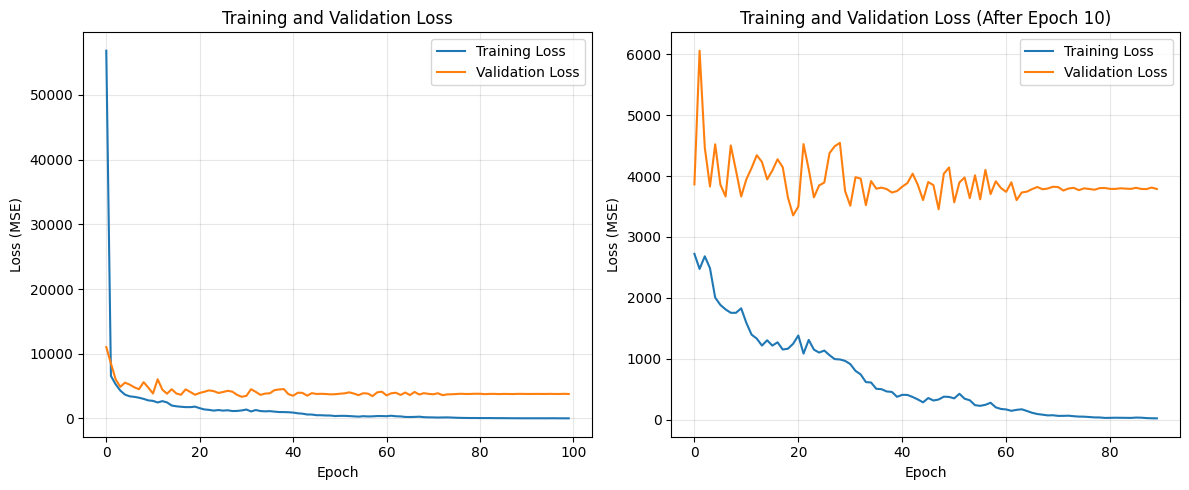

In [93]:
# Plot training curves
def plot_training_curves(train_losses, val_losses):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(train_losses[10:], label='Training Loss')
    plt.plot(val_losses[10:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss (After Epoch 10)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

plot_training_curves(best_train_losses, best_val_losses)

In [94]:
# Load best model
model.load_state_dict(torch.load('model.pth'))
model.eval()

# Make predictions on test set
all_predictions = []
all_targets = []
wmae = 0.0

with torch.no_grad():
    for sales_backcast, sales_forecast_true, holiday_forecast in val_loader:
        sales_backcast = sales_backcast.to(device)
        sales_forecast_true = sales_forecast_true.to(device)
        holiday_forecast = holiday_forecast.to(device)

        sales_forecast_pred = model(sales_backcast)
        wmae = criterion(sales_forecast_pred, sales_forecast_true, holiday_forecast).item()

        all_predictions.extend(sales_forecast_pred.cpu().numpy())
        all_targets.extend(sales_forecast_true.cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

print(f"Predictions shape: {all_predictions.shape}")
print(f"Targets shape: {all_targets.shape}")

Predictions shape: (1, 30)
Targets shape: (1, 30)


In [95]:
print(f"Weighted Mean Absolute Error (WMAE): {wmae:.6f}")

Weighted Mean Absolute Error (WMAE): 3786.935059


# Prediction

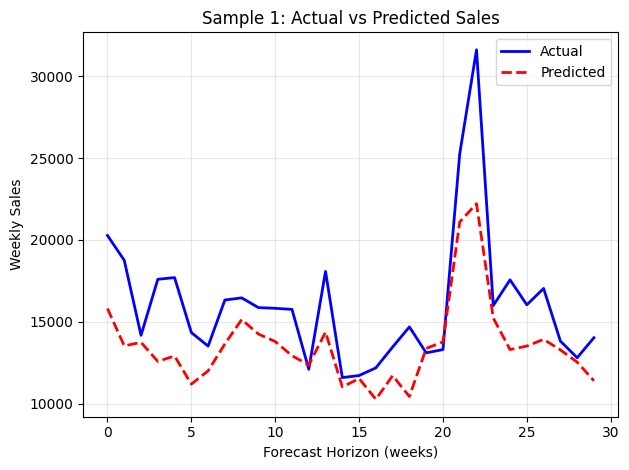

In [96]:
# Visualize predictions
num_samples_to_plot = min(5, len(all_predictions))

for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)

    # Plot actual vs predicted
    time_steps = range(FORECAST_LENGTH)
    plt.plot(time_steps, all_targets[i], 'b-', label='Actual', linewidth=2)
    plt.plot(time_steps, all_predictions[i], 'r--', label='Predicted', linewidth=2)

    plt.xlabel('Forecast Horizon (weeks)')
    plt.ylabel('Weekly Sales')
    plt.title(f'Sample {i+1}: Actual vs Predicted Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions.png')
plt.show()

Analyzing N-BEATS Model Components...
Trend Stack Contribution:
  - Forecast mean: 13028.55
  - Forecast std: 1876.60
  - Forecast range: [10067.27, 16245.51]
Trend Stack Contribution:
  - Forecast mean: 165.83
  - Forecast std: 8.40
  - Forecast range: [147.43, 173.87]
Seasonality Stack Contribution:
  - Forecast mean: 245.82
  - Forecast std: 1394.71
  - Forecast range: [-3161.64, 2161.18]
Generic Stack Contribution:
  - Forecast mean: 130.99
  - Forecast std: 2166.14
  - Forecast range: [-3268.68, 5272.88]

Visualizing Stack Contributions...


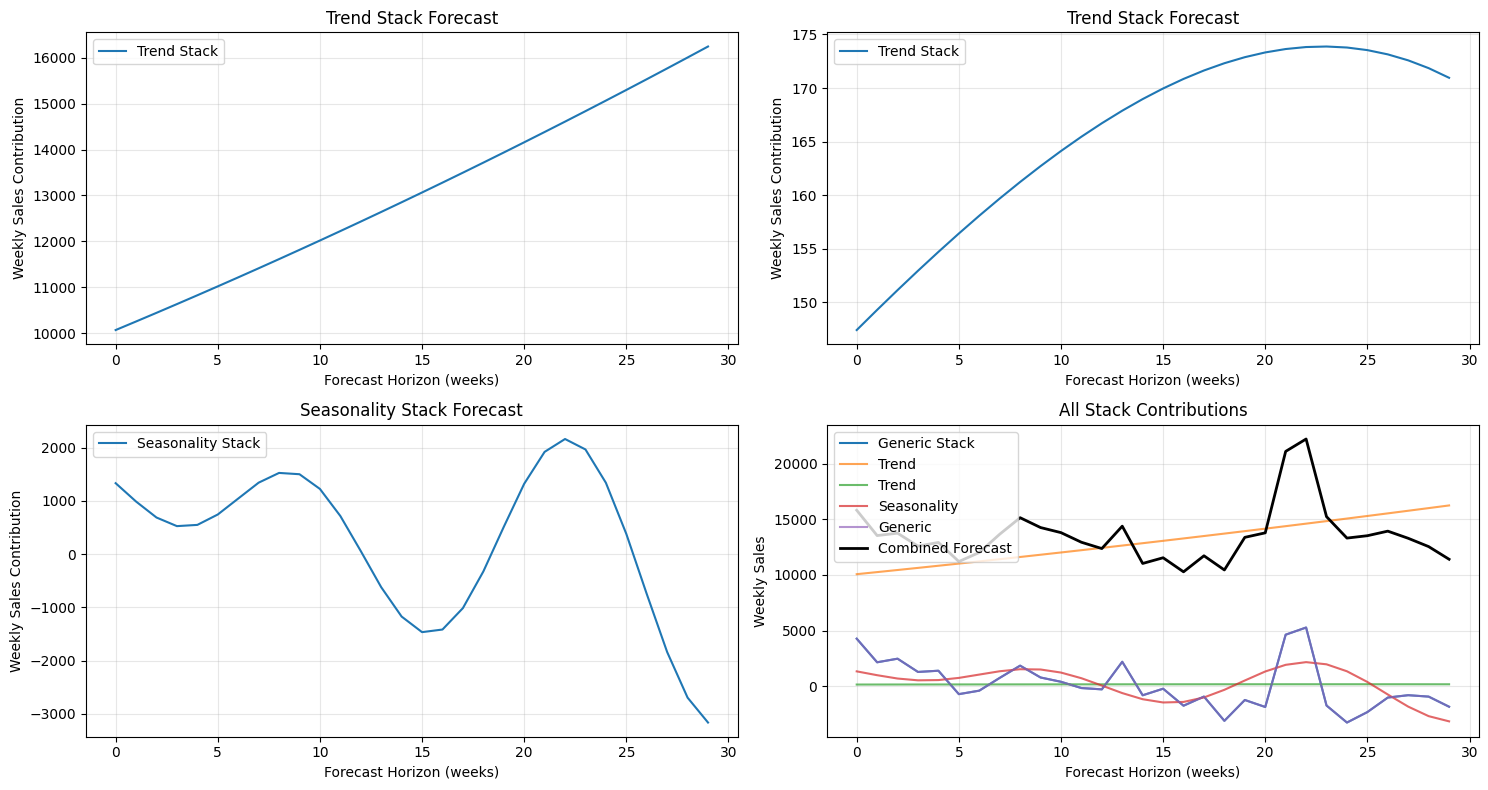

In [97]:
# Model Interpretation Functions

def analyze_model_components(model, sample_data, device):
    """
    Analyze individual stack contributions to understand what each part of the model learns
    """
    model.eval()
    sample_data = sample_data.to(device)

    # Store intermediate outputs
    stack_forecasts = []
    residuals = sample_data.clone()

    with torch.no_grad():
        for i, stack in enumerate(model.stacks):
            stack_residuals, stack_forecast = stack(residuals)
            stack_forecasts.append(stack_forecast.cpu().numpy())
            residuals = stack_residuals

            print(f"{model.stack_types[i].title()} Stack Contribution:")
            print(f"  - Forecast mean: {stack_forecast.mean().item():.2f}")
            print(f"  - Forecast std: {stack_forecast.std().item():.2f}")
            print(f"  - Forecast range: [{stack_forecast.min().item():.2f}, {stack_forecast.max().item():.2f}]")

    return stack_forecasts

def plot_stack_contributions(stack_forecasts, stack_types):
    """
    Visualize how different stacks contribute to the final prediction
    """
    plt.figure(figsize=(15, 8))

    # Plot individual stack contributions
    for i, (forecast, stack_type) in enumerate(zip(stack_forecasts, stack_types)):
        plt.subplot(2, 2, i+1)
        plt.plot(forecast[0], label=f'{stack_type.title()} Stack')
        plt.title(f'{stack_type.title()} Stack Forecast')
        plt.xlabel('Forecast Horizon (weeks)')
        plt.ylabel('Weekly Sales Contribution')
        plt.grid(True, alpha=0.3)
        plt.savefig('stack_contributions.png')
        plt.legend()

    # Plot combined contributions
    plt.subplot(2, 2, 4)
    combined_forecast = np.sum(stack_forecasts, axis=0)[0]

    for i, (forecast, stack_type) in enumerate(zip(stack_forecasts, stack_types)):
        plt.plot(forecast[0], label=f'{stack_type.title()}', alpha=0.7)

    plt.plot(combined_forecast, 'k-', linewidth=2, label='Combined Forecast')
    plt.title('All Stack Contributions')
    plt.xlabel('Forecast Horizon (weeks)')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('combined_contributions.png')
    plt.show()

def interpret_forecast_patterns(predictions, targets, forecast_length):
    """
    Analyze forecast patterns and performance across the forecast horizon
    """
    # Calculate errors at each forecast step
    errors = np.abs(predictions - targets)
    mae_by_step = np.mean(errors, axis=0)

    # Calculate relative importance of each forecast step
    forecast_variance = np.var(predictions, axis=0)

    plt.figure(figsize=(15, 5))

    # MAE by forecast step
    plt.subplot(1, 2, 1)
    plt.plot(range(1, forecast_length + 1), mae_by_step, 'b-o')
    plt.title('Mean Absolute Error by Forecast Step')
    plt.xlabel('Forecast Step (weeks ahead)')
    plt.ylabel('MAE')
    plt.grid(True, alpha=0.3)

    # Error distribution
    plt.subplot(1, 2, 2)
    plt.hist(errors.flatten(), bins=30, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Forecast Errors')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('forecast_patterns.png')
    plt.show()

    # Print interpretation
    print("Forecast Pattern Analysis:")
    print(f"- Best performing step: Week {np.argmin(mae_by_step) + 1} (MAE: {np.min(mae_by_step):.2f})")
    print(f"- Worst performing step: Week {np.argmax(mae_by_step) + 1} (MAE: {np.max(mae_by_step):.2f})")
    print(f"- Overall forecast confidence decreases over time: {mae_by_step[0] < mae_by_step[-1]}")
    print(f"- Average error across all steps: {np.mean(mae_by_step):.2f}")

# Analyze the trained model
print("Analyzing N-BEATS Model Components...")
print("=" * 50)

# Take a sample from validation data for analysis
sample_backcast, _, _ = next(iter(val_loader))
stack_contributions = analyze_model_components(model, sample_backcast[:1], device)

print("\n" + "=" * 50)
print("Visualizing Stack Contributions...")
plot_stack_contributions(stack_contributions, model.stack_types)

Analyzing Forecast Patterns and Performance...


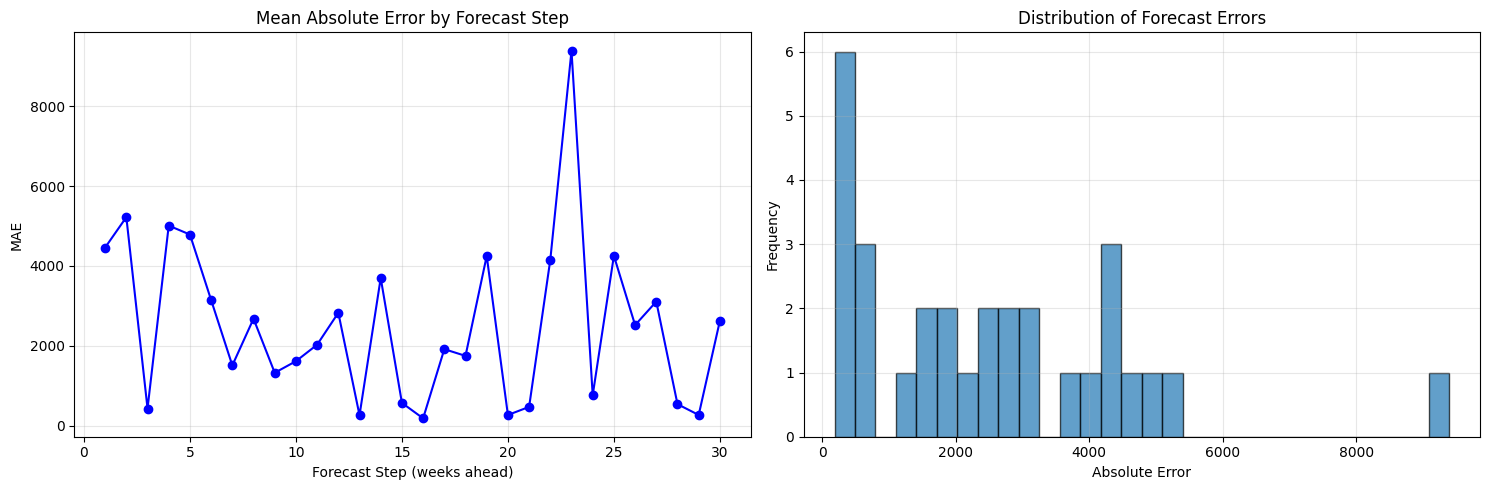

Forecast Pattern Analysis:
- Best performing step: Week 16 (MAE: 183.46)
- Worst performing step: Week 23 (MAE: 9392.33)
- Overall forecast confidence decreases over time: False
- Average error across all steps: 2534.62


In [98]:
# Analyze Forecast Patterns
print("Analyzing Forecast Patterns and Performance...")
print("=" * 50)

interpret_forecast_patterns(all_predictions, all_targets, FORECAST_LENGTH)

Analyzing Input Sensitivity...


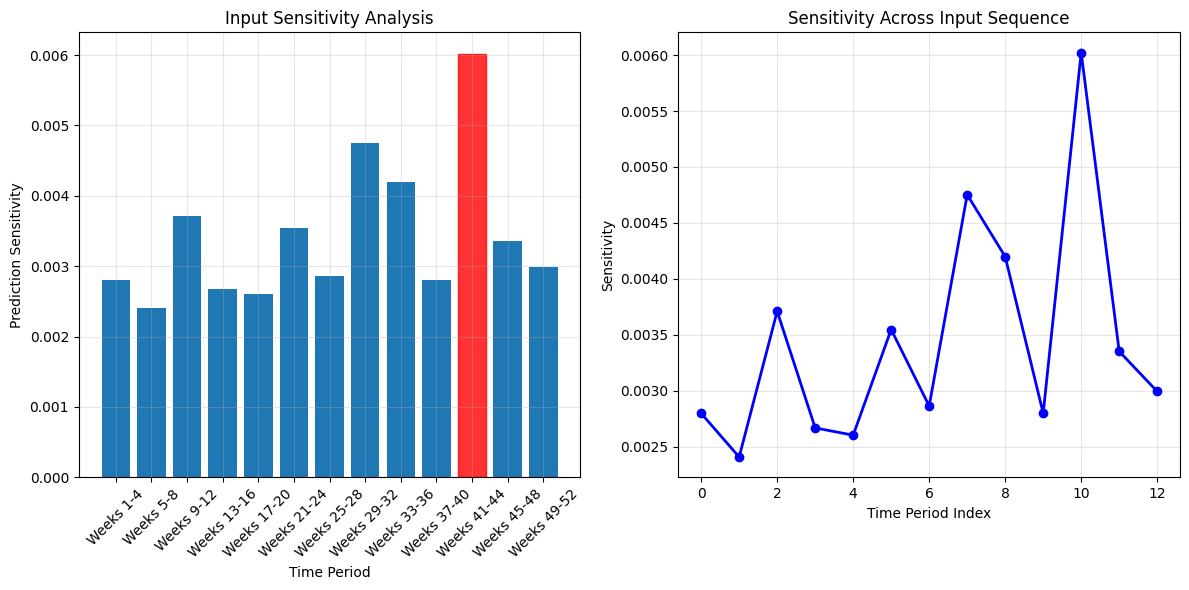

Input Sensitivity Analysis:
- Most sensitive period: Weeks 41-44 (Sensitivity: 0.0060)
- Least sensitive period: Weeks 5-8 (Sensitivity: 0.0024)
- Recent data importance: Low


In [99]:
def analyze_input_sensitivity(model, sample_data, device, perturbation_size=0.1):
    """
    Analyze how sensitive the model is to different parts of the input sequence
    This helps understand which time periods are most important for forecasting
    """
    model.eval()
    original_data = sample_data.to(device)

    with torch.no_grad():
        # Get baseline prediction
        baseline_pred = model(original_data)

        # Analyze sensitivity to different time periods
        sensitivities = []
        time_periods = []

        # Test sensitivity by perturbing different parts of the input
        window_size = 4  # Perturb 4 weeks at a time

        for start_idx in range(0, original_data.size(1) - window_size + 1, window_size):
            perturbed_data = original_data.clone()

            # Add noise to a specific time window
            noise = torch.randn_like(perturbed_data[:, start_idx:start_idx + window_size]) * perturbation_size
            perturbed_data[:, start_idx:start_idx + window_size] += noise

            # Get prediction with perturbed data
            perturbed_pred = model(perturbed_data)

            # Calculate change in prediction
            sensitivity = torch.mean(torch.abs(perturbed_pred - baseline_pred)).item()
            sensitivities.append(sensitivity)
            time_periods.append(f"Weeks {start_idx+1}-{start_idx+window_size}")

    return sensitivities, time_periods

def plot_input_sensitivity(sensitivities, time_periods):
    """
    Visualize which parts of the input sequence are most important
    """
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    bars = plt.bar(range(len(sensitivities)), sensitivities)
    plt.title('Input Sensitivity Analysis')
    plt.xlabel('Time Period')
    plt.ylabel('Prediction Sensitivity')
    plt.xticks(range(len(time_periods)), time_periods, rotation=45)
    plt.grid(True, alpha=0.3)

    # Highlight most sensitive periods
    max_sensitivity_idx = np.argmax(sensitivities)
    bars[max_sensitivity_idx].set_color('red')
    bars[max_sensitivity_idx].set_alpha(0.8)

    plt.subplot(1, 2, 2)
    # Show sensitivity over time (assuming sequential periods)
    plt.plot(sensitivities, 'b-o', linewidth=2, markersize=6)
    plt.title('Sensitivity Across Input Sequence')
    plt.xlabel('Time Period Index')
    plt.ylabel('Sensitivity')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('input_sensitivity.png')
    plt.show()

    print("Input Sensitivity Analysis:")
    print(f"- Most sensitive period: {time_periods[max_sensitivity_idx]} (Sensitivity: {sensitivities[max_sensitivity_idx]:.4f})")
    print(f"- Least sensitive period: {time_periods[np.argmin(sensitivities)]} (Sensitivity: {np.min(sensitivities):.4f})")
    print(f"- Recent data importance: {'High' if sensitivities[-1] > np.mean(sensitivities) else 'Low'}")

# Perform sensitivity analysis
print("Analyzing Input Sensitivity...")
print("=" * 50)

sample_backcast, _, _ = next(iter(val_loader))
sensitivities, time_periods = analyze_input_sensitivity(model, sample_backcast[:1], device)
plot_input_sensitivity(sensitivities, time_periods)

# Start MLFlow

In [82]:
!pip install dagshub mlflow -Uq

In [83]:
import dagshub
import mlflow
from mlflow.models.signature import infer_signature
dagshub.init(repo_owner='Cimbir', repo_name='Store-Sales-Forecasting', mlflow=True)

Initialized MLflow to track repo "Cimbir/Store-Sales-Forecasting"

Repository Cimbir/Store-Sales-Forecasting initialized!

In [84]:
mlflow.set_experiment('N-BEATS_Training')

<Experiment: artifact_location='mlflow-artifacts:/30e70b0cc1fc4646a313316bba45522c', creation_time=1751484415802, experiment_id='3', last_update_time=1751484415802, lifecycle_stage='active', name='N-BEATS_Training', tags={}>

In [100]:
with open('grid_search_results.txt', 'w') as f:
    # Write overall summary
    f.write(f"Grid Search Summary:\n")
    f.write(f"Backcast Length: {BACKCAST_LENGTH}\n")
    f.write(f"Forecast Length: {FORECAST_LENGTH}\n")
    f.write(f"Number of Trials: {len(results)}\n")
    f.write(f"Best WMAE Found: {best_val_loss:.6f}\n")
    f.write(f"Best Parameters:\n")
    for key, value in best_params.items():
        f.write(f"  {key}: {value}\n")
    f.write("-" * 50 + "\n")

    # Write individual trial results
    f.write("Trial Results (Sorted by WMAE):\n")
    for params, loss in results:
        f.write(f"  WMAE: {loss:.6f}\n")
        f.write(f"  Parameters:\n")
        for key, value in params.items():
            f.write(f"    {key}: {value}\n")
        f.write("-" * 30 + "\n")

print("Grid search results written to grid_search_results.txt")

with open('random_search_results.txt', 'w') as f:
    # Write overall summary
    f.write(f"Random Search Summary:\n")
    f.write(f"Backcast Length: {BACKCAST_LENGTH}\n")
    f.write(f"Forecast Length: {FORECAST_LENGTH}\n")
    f.write(f"Number of Trials: {len(results)}\n")
    f.write(f"Best WMAE Found: {best_val_loss:.6f}\n")
    f.write(f"Best Parameters:\n")
    for key, value in best_params.items():
        f.write(f"  {key}: {value}\n")
    f.write("-" * 50 + "\n")

    # Write individual trial results
    f.write("Trial Results (Sorted by WMAE):\n")
    for params, loss in results:
        f.write(f"  WMAE: {loss:.6f}\n")
        f.write(f"  Parameters:\n")
        for key, value in params.items():
            f.write(f"    {key}: {value}\n")
        f.write("-" * 30 + "\n")

print("Random search results written to random_search_results.txt")


Grid search results written to grid_search_results.txt
Random search results written to random_search_results.txt


In [101]:
with mlflow.start_run(run_name=f'N-BEATS_Model_{store_id}_{dept_id}_grid_search_stacks') as run:
  mlflow.log_param('store_id', store_id)
  mlflow.log_param('dept_id', dept_id)

  mlflow.log_param('search_method', 'grid')
  mlflow.log_param('search_space', search_space)
  mlflow.log_param('best_params', best_params)
  mlflow.log_param('backcast', BACKCAST_LENGTH)
  mlflow.log_param('forecast', FORECAST_LENGTH)
  mlflow.log_param('epochs', EPOCHS)
  mlflow.log_param('trials', TRIALS)

  mlflow.log_metric('best_train_losses', sum(best_train_losses) / len(best_train_losses))
  mlflow.log_metric('best_val_losses', sum(best_val_losses) / len(best_val_losses))
  mlflow.log_metric('best_wmae', best_val_loss)

  mlflow.log_text(str(best_model), 'model_summary.txt')

  mlflow.log_artifact('training_curves.png')
  mlflow.log_artifact('predictions.png')
  mlflow.log_artifact('stack_contributions.png')
  mlflow.log_artifact('combined_contributions.png')
  mlflow.log_artifact('forecast_patterns.png')
  mlflow.log_artifact('input_sensitivity.png')
  mlflow.log_artifact('random_search.txt')

  mlflow.log_artifact('model.pth')

🏃 View run N-BEATS_Model_9_9_grid_search_stacks at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/3/runs/858a428f4951410883dd6499204104c5
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/3
